In [339]:
import polars.selectors as cs
import numpy as np

import polars as pl
import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


In [340]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    10: ['c_custkey', 'c_name', 'c_acctbal', 'c_phone', 'n_name', 'c_address', 'c_comment'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
# why not 1??
scale_required = set([1,4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [341]:
q4_dp = {'1-URGENT': [14.313106008677043,
  10.600769977371808,
  7.332454827958597,
  5.054943602792854,
  3.3326913722116016,
  2.167712088939863,
  1.2571531166398893,
  0.3261987554688212,
  0.30239416083368864,
  0.3256621350104104],
 '2-HIGH': [14.170831183010021,
  9.898314979883413,
  7.091756560504648,
  5.066494162339437,
  3.4282939914794723,
  2.1937518412168893,
  1.1762028057411633,
  0.3157340851229058,
  0.3129588941535568,
  0.3118813324471594],
 '3-MEDIUM': [13.565153723153122,
  9.392894896729493,
  6.911182805236071,
  4.5335345421257305,
  3.2649720412192034,
  2.178082401296948,
  1.135747769419987,
  0.28341733597690466,
  0.304211051158086,
  0.30629725468183866],
 '4-NOT SPECIFIED': [14.223164553117483,
  10.378832942663056,
  7.293690681730415,
  4.892222374694089,
  3.391766754407505,
  2.2463353810332642,
  1.2395202643043342,
  0.30933010045271847,
  0.31390880852233877,
  0.31265765242991395],
 '5-LOW': [13.837545022379228,
  9.066546056818154,
  6.572375786596896,
  4.568676705660714,
  3.1251144261664305,
  1.9287832489716779,
  1.1376053989920165,
  0.30179316044835447,
  0.29789786500138865,
  0.2876195075167477]}

In [342]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15,10), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range

    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
                print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        linewidth=3)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative\nError (%)', fontsize=15)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=20)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figs/q1_results.png')

In [343]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=20)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figs/q14_results.png')

In [344]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', linewidth=3,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)


        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figs/q12_results.png')

In [345]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

In [346]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', linewidth=3)
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', linewidth=3)

        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating Order Count Difference % ({labels[i]})', fontsize=18)
        ax.grid(True, alpha=0.3)
        plt.subplots_adjust(hspace=0.6)  # hspace controls vertical spacing
    handles, labels_legend = axes[0].get_legend_handles_labels()
#         fig.legend(handles, labels_legend, bbox_to_anchor=(0.5, -0.01), 
#                   loc='upper center', ncol=3, fontsize=16)
    fig.legend(handles, labels_legend,
               loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.2))

    plt.savefig('../figs/q4_results.png', bbox_inches='tight')

In [351]:
for query_ind in queries_to_run:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        if query_ind == 10:
            orig = orig.select(
                pl.col("c_custkey"), pl.col("c_name"),
                pl.col("c_acctbal").cast(str),
                pl.col("n_name"), pl.col("c_address"), pl.col("c_phone"), pl.col("c_comment")
            )
        noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                        if query_ind == 1 and not (base_name[:3] == 'sum' or base_name[:5] == 'count'):
                            const = 1 # remove for parts of q1
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    noised_vals = [merged_df[noised][ind][tmp_ind] for tmp_ind in range(
                        len(merged_df[noised][ind])) if merged_df[noised][ind][tmp_ind] is not None]
                    print(merged_df[noised])
                    new = np.average(
                        [100*abs(
                            const*noised_vals[tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(noised_vals))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
#     graph_query(full_df, query_ind)

shape: (4,)
Series: 'sum_qty_noised' [list[f64]]
[
	[1.8718e6, 1.8771e6, … 1.9699e6]
	[38478.368506, 40914.207363, … 55473.30775]
	[4.2677e6, 3.3495e6, … 3.9850e6]
	[2.1541e6, 1.7809e6, … 2.4365e6]
]
shape: (4,)
Series: 'sum_qty_noised' [list[f64]]
[
	[1.8718e6, 1.8771e6, … 1.9699e6]
	[38478.368506, 40914.207363, … 55473.30775]
	[4.2677e6, 3.3495e6, … 3.9850e6]
	[2.1541e6, 1.7809e6, … 2.4365e6]
]
shape: (4,)
Series: 'sum_qty_noised' [list[f64]]
[
	[1.8718e6, 1.8771e6, … 1.9699e6]
	[38478.368506, 40914.207363, … 55473.30775]
	[4.2677e6, 3.3495e6, … 3.9850e6]
	[2.1541e6, 1.7809e6, … 2.4365e6]
]
shape: (4,)
Series: 'sum_qty_noised' [list[f64]]
[
	[1.8718e6, 1.8771e6, … 1.9699e6]
	[38478.368506, 40914.207363, … 55473.30775]
	[4.2677e6, 3.3495e6, … 3.9850e6]
	[2.1541e6, 1.7809e6, … 2.4365e6]
]
shape: (4,)
Series: 'count_order_noised' [list[f64]]
[
	[74229.426235, 72018.256861, … 82372.964827]
	[1623.654508, 1865.555996, … 2068.456669]
	[167467.841605, 143447.062214, … 140286.106238]
	[75566

shape: (4,)
Series: 'sum_charge_noised' [list[f64]]
[
	[2.5683e9, 2.7637e9, … 2.6692e9]
	[5.7329e7, 7.3063e7, … 5.1597e7]
	[5.3539e9, 4.3250e9, … 4.8719e9]
	[2.6397e9, 2.5545e9, … 2.7212e9]
]
shape: (4,)
Series: 'sum_charge_noised' [list[f64]]
[
	[2.5683e9, 2.7637e9, … 2.6692e9]
	[5.7329e7, 7.3063e7, … 5.1597e7]
	[5.3539e9, 4.3250e9, … 4.8719e9]
	[2.6397e9, 2.5545e9, … 2.7212e9]
]
shape: (4,)
Series: 'sum_charge_noised' [list[f64]]
[
	[2.5683e9, 2.7637e9, … 2.6692e9]
	[5.7329e7, 7.3063e7, … 5.1597e7]
	[5.3539e9, 4.3250e9, … 4.8719e9]
	[2.6397e9, 2.5545e9, … 2.7212e9]
]
shape: (4,)
Series: 'sum_charge_noised' [list[f64]]
[
	[2.5683e9, 2.7637e9, … 2.6692e9]
	[5.7329e7, 7.3063e7, … 5.1597e7]
	[5.3539e9, 4.3250e9, … 4.8719e9]
	[2.6397e9, 2.5545e9, … 2.7212e9]
]
shape: (4,)
Series: 'sum_qty_noised' [list[f64]]
[
	[1.8863e6, 1.7536e6, … 1.8969e6]
	[49290.033414, 58263.578589, … 48088.310499]
	[3.8156e6, 3.7568e6, … 3.4403e6]
	[1.9899e6, 1.7796e6, … 1.9785e6]
]
shape: (4,)
Series: 'sum_qty_no

shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.552416, 25.668459, … 25.541072]
	[25.508002, 25.218216, … 26.434161]
	[25.621288, 25.594742, … 25.602514]
	[25.461329, 25.357806, … 25.482065]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.552416, 25.668459, … 25.541072]
	[25.508002, 25.218216, … 26.434161]
	[25.621288, 25.594742, … 25.602514]
	[25.461329, 25.357806, … 25.482065]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.552416, 25.668459, … 25.541072]
	[25.508002, 25.218216, … 26.434161]
	[25.621288, 25.594742, … 25.602514]
	[25.461329, 25.357806, … 25.482065]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.552416, 25.668459, … 25.541072]
	[25.508002, 25.218216, … 26.434161]
	[25.621288, 25.594742, … 25.602514]
	[25.461329, 25.357806, … 25.482065]
]
shape: (4,)
Series: 'sum_base_price_noised' [list[f64]]
[
	[2.7669e9, 2.4782e9, … 2.4713e9]
	[7.1485e7, 7.4582e7, … 7.1994e7]
	[5.2481e9, 5.2463e9, … 5.0580e9]
	[2.6317e9, 2.5770e9, … 2.5536e9]
]


shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.532294, 25.437535, … 25.485734]
	[24.98188, 24.527503, … 25.797246]
	[25.654503, 25.515915, … 25.614755]
	[25.491777, 25.61263, … 25.64206]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.532294, 25.437535, … 25.485734]
	[24.98188, 24.527503, … 25.797246]
	[25.654503, 25.515915, … 25.614755]
	[25.491777, 25.61263, … 25.64206]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.532294, 25.437535, … 25.485734]
	[24.98188, 24.527503, … 25.797246]
	[25.654503, 25.515915, … 25.614755]
	[25.491777, 25.61263, … 25.64206]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.532294, 25.437535, … 25.485734]
	[24.98188, 24.527503, … 25.797246]
	[25.654503, 25.515915, … 25.614755]
	[25.491777, 25.61263, … 25.64206]
]
shape: (4,)
Series: 'sum_base_price_noised' [list[f64]]
[
	[2.7027e9, 2.7009e9, … 2.6457e9]
	[6.3605e7, 6.7530e7, … 7.1067e7]
	[5.3231e9, 5.1960e9, … 5.0132e9]
	[2.6791e9, 2.7130e9, … 2.7370e9]
]
shape: (4,)


shape: (4,)
Series: 'sum_disc_price_noised' [list[f64]]
[
	[2.4826e9, 2.4754e9, … 2.5273e9]
	[6.3020e7, 6.6119e7, … 6.4765e7]
	[4.9806e9, 4.8918e9, … 4.9547e9]
	[2.4943e9, 2.5841e9, … 2.5424e9]
]
shape: (4,)
Series: 'sum_disc_price_noised' [list[f64]]
[
	[2.4826e9, 2.4754e9, … 2.5273e9]
	[6.3020e7, 6.6119e7, … 6.4765e7]
	[4.9806e9, 4.8918e9, … 4.9547e9]
	[2.4943e9, 2.5841e9, … 2.5424e9]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.527544, 25.510893, … 25.52159]
	[24.876394, 26.325129, … 25.303169]
	[25.522745, 25.542369, … 25.533985]
	[25.511891, 25.541826, … 25.545256]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.527544, 25.510893, … 25.52159]
	[24.876394, 26.325129, … 25.303169]
	[25.522745, 25.542369, … 25.533985]
	[25.511891, 25.541826, … 25.545256]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.527544, 25.510893, … 25.52159]
	[24.876394, 26.325129, … 25.303169]
	[25.522745, 25.542369, … 25.533985]
	[25.511891, 25.541826, … 25.545256]
]
shape: (

shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.565656, 25.578986, … 25.515086]
	[25.18602, 25.515608, … 25.265631]
	[25.5769, 25.655777, … 25.556284]
	[25.525526, 25.495271, … 25.531972]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.565656, 25.578986, … 25.515086]
	[25.18602, 25.515608, … 25.265631]
	[25.5769, 25.655777, … 25.556284]
	[25.525526, 25.495271, … 25.531972]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.565656, 25.578986, … 25.515086]
	[25.18602, 25.515608, … 25.265631]
	[25.5769, 25.655777, … 25.556284]
	[25.525526, 25.495271, … 25.531972]
]
shape: (4,)
Series: 'avg_qty_noised' [list[f64]]
[
	[25.565656, 25.578986, … 25.515086]
	[25.18602, 25.515608, … 25.265631]
	[25.5769, 25.655777, … 25.556284]
	[25.525526, 25.495271, … 25.531972]
]
shape: (4,)
Series: 'sum_base_price_noised' [list[f64]]
[
	[2.6115e9, 2.6399e9, … 2.6545e9]
	[6.5904e7, 6.4345e7, … 6.5458e7]
	[5.2699e9, 5.2550e9, … 5.1757e9]
	[2.6884e9, 2.7047e9, … 2.7348e9]
]
shape: (4,)


shape: (5,)
Series: 'order_count_noised' [list[f64]]
[
	[502.078192, 513.851557, … 471.74651]
	[504.170262, 478.55834, … 516.284321]
	[515.502463, 525.536636, … 507.405603]
	[502.705613, 523.389206, … 474.635202]
	[548.938221, 501.48396, … 543.858722]
]
shape: (5,)
Series: 'order_count_noised' [list[f64]]
[
	[502.078192, 513.851557, … 471.74651]
	[504.170262, 478.55834, … 516.284321]
	[515.502463, 525.536636, … 507.405603]
	[502.705613, 523.389206, … 474.635202]
	[548.938221, 501.48396, … 543.858722]
]
shape: (5,)
Series: 'order_count_noised' [list[f64]]
[
	[502.078192, 513.851557, … 471.74651]
	[504.170262, 478.55834, … 516.284321]
	[515.502463, 525.536636, … 507.405603]
	[502.705613, 523.389206, … 474.635202]
	[548.938221, 501.48396, … 543.858722]
]
shape: (5,)
Series: 'order_count_noised' [list[f64]]
[
	[502.078192, 513.851557, … 471.74651]
	[504.170262, 478.55834, … 516.284321]
	[515.502463, 525.536636, … 507.405603]
	[502.705613, 523.389206, … 474.635202]
	[548.938221, 501.48396, 

shape: (5,)
Series: 'revenue_noised' [list[f64]]
[
	[4.7067e6, 4.1261e6, … 4.4580e6]
	[3.5428e6, 3.5702e6, … 2.6118e6]
	[2.5018e6, 3.2889e6, … 2.5858e6]
	[3.7888e6, 2.6093e6, … 3.8555e6]
	[2.3308e6, 2.3783e6, … 2.7731e6]
]
shape: (5,)
Series: 'revenue_noised' [list[f64]]
[
	[4.7067e6, 4.1261e6, … 4.4580e6]
	[3.5428e6, 3.5702e6, … 2.6118e6]
	[2.5018e6, 3.2889e6, … 2.5858e6]
	[3.7888e6, 2.6093e6, … 3.8555e6]
	[2.3308e6, 2.3783e6, … 2.7731e6]
]
shape: (5,)
Series: 'revenue_noised' [list[f64]]
[
	[4.7067e6, 4.1261e6, … 4.4580e6]
	[3.5428e6, 3.5702e6, … 2.6118e6]
	[2.5018e6, 3.2889e6, … 2.5858e6]
	[3.7888e6, 2.6093e6, … 3.8555e6]
	[2.3308e6, 2.3783e6, … 2.7731e6]
]
shape: (5,)
Series: 'revenue_noised' [list[f64]]
[
	[4.7067e6, 4.1261e6, … 4.4580e6]
	[3.5428e6, 3.5702e6, … 2.6118e6]
	[2.5018e6, 3.2889e6, … 2.5858e6]
	[3.7888e6, 2.6093e6, … 3.8555e6]
	[2.3308e6, 2.3783e6, … 2.7731e6]
]
shape: (5,)
Series: 'revenue_noised' [list[f64]]
[
	[4.7067e6, 4.1261e6, … 4.4580e6]
	[3.5428e6, 3.5702e6, …

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.5185e6, 2.1746e6, … -1.0124e6]
	[287664.35716, 1.5310e6, … 3.4360e6]
	[3.5777e6, 2.3994e6, … 1.6945e6]
	[2.7899e6, -246108.047724, … 212615.592355]
	[2.2223e6, 2.8350e6, … -718839.92371]
	…
	[3.0835e6, 2.8433e6, … -178396.657169]
	[2.3791e6, 2.1926e6, … 2.4878e6]
	[2.5408e6, 925423.076286, … 1.6745e6]
	[727925.131537, 1.4708e6, … 2.4977e6]
	[2.0283e6, 356709.823999, … -398029.302312]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.5185e6, 2.1746e6, … -1.0124e6]
	[287664.35716, 1.5310e6, … 3.4360e6]
	[3.5777e6, 2.3994e6, … 1.6945e6]
	[2.7899e6, -246108.047724, … 212615.592355]
	[2.2223e6, 2.8350e6, … -718839.92371]
	…
	[3.0835e6, 2.8433e6, … -178396.657169]
	[2.3791e6, 2.1926e6, … 2.4878e6]
	[2.5408e6, 925423.076286, … 1.6745e6]
	[727925.131537, 1.4708e6, … 2.4977e6]
	[2.0283e6, 356709.823999, … -398029.302312]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.5185e6, 2.1746e6, … -1.0124e6]
	[287664.35

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e6, … 811826.671134]
	[1.5852e6, 1.9277e6, … 1.9961e6]
	[1.4246e6, 2.0138e6, … 3.7179e6]
	…
	[1.7160e6, 2.3609e6, … 795635.995417]
	[1.6872e6, 723169.331295, … 1.4614e6]
	[3.3436e6, 112616.020664, … 2.9451e6]
	[1.3804e6, 1.2106e6, … 1.1709e6]
	[2.2892e6, 1.5626e6, … 2.1956e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e6, … 811826.671134]
	[1.5852e6, 1.9277e6, … 1.9961e6]
	[1.4246e6, 2.0138e6, … 3.7179e6]
	…
	[1.7160e6, 2.3609e6, … 795635.995417]
	[1.6872e6, 723169.331295, … 1.4614e6]
	[3.3436e6, 112616.020664, … 2.9451e6]
	[1.3804e6, 1.2106e6, … 1.1709e6]
	[2.2892e6, 1.5626e6, … 2.1956e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e6, … 811826.671134]
	[1.5852e6, 1.9277e6, … 1.9961e6]
	[1.4246e6, 2.0138e6, … 3.7179e6]
	…
	[1.7160e6, 2.3609e6, … 795635.995417]
	[1.6872e6, 723169.331295, … 1.4614e6]
	[3.3436e6, 112616.020664, … 2.9451e6]
	[1.3804e6, 1.2106e6, … 1.1709e6]
	[2.2892e6, 1.5626e6, … 2.1956e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e6, … 811826.671134]
	[1.5852e6, 1.9277e6, … 1.9961e6]
	[1.4246e6, 2.0138e6, … 3.7179e6]
	…
	[1.7160e6, 2.3609e6, … 795635.995417]
	[1.6872e6, 723169.331295, … 1.4614e6]
	[3.3436e6, 112616.020664, … 2.9451e6]
	[1.3804e6, 1.2106e6, … 1.1709e6]
	[2.2892e6, 1.5626e6, … 2.1956e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.6075e6, 1.1849e6, … 1.6449e6]
	[295430.812572, 1.7742e6, … 1.1641e6]
	[3.2149e6, 2.4235e

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[727214.94507, 545628.162648, … 1.5267e6]
	[1.9476e6, 2.4841e6, … 2.2482e6]
	[1.9261e6, 1.5874e6, … 2.7071e6]
	[2.9547e6, 3.5676e6, … 1.4684e6]
	[2.9220e6, 2.4625e6, … 2.0795e6]
	…
	[1.2242e6, 2.2550e6, … 2.2549e6]
	[1.2311e6, 1.4268e6, … 2.3401e6]
	[3.5020e6, 1.8692e6, … 2.3783e6]
	[1.1000e6, 1.8741e6, … 1.8608e6]
	[1.4082e6, 2.1310e6, … 2.8741e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[727214.94507, 545628.162648, … 1.5267e6]
	[1.9476e6, 2.4841e6, … 2.2482e6]
	[1.9261e6, 1.5874e6, … 2.7071e6]
	[2.9547e6, 3.5676e6, … 1.4684e6]
	[2.9220e6, 2.4625e6, … 2.0795e6]
	…
	[1.2242e6, 2.2550e6, … 2.2549e6]
	[1.2311e6, 1.4268e6, … 2.3401e6]
	[3.5020e6, 1.8692e6, … 2.3783e6]
	[1.1000e6, 1.8741e6, … 1.8608e6]
	[1.4082e6, 2.1310e6, … 2.8741e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[727214.94507, 545628.162648, … 1.5267e6]
	[1.9476e6, 2.4841e6, … 2.2482e6]
	[1.9261e6, 1.5874e6, … 2.7071e6]
	[2.9547e6, 3

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[926252.409058, 1.1331e6, … 1.0670e6]
	[2.5395e6, 2.2743e6, … 1.9944e6]
	[1.8164e6, 1.8703e6, … 2.2459e6]
	[1.4854e6, 2.6284e6, … 1.9653e6]
	[2.8718e6, 2.1862e6, … 1.6002e6]
	…
	[2.1625e6, 1.6210e6, … 2.1425e6]
	[2.6723e6, 1.8657e6, … 1.8327e6]
	[2.0351e6, 1.2748e6, … 1.4296e6]
	[1.5574e6, 1.0688e6, … 1.6438e6]
	[2.9698e6, 1.7515e6, … 1.4572e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[926252.409058, 1.1331e6, … 1.0670e6]
	[2.5395e6, 2.2743e6, … 1.9944e6]
	[1.8164e6, 1.8703e6, … 2.2459e6]
	[1.4854e6, 2.6284e6, … 1.9653e6]
	[2.8718e6, 2.1862e6, … 1.6002e6]
	…
	[2.1625e6, 1.6210e6, … 2.1425e6]
	[2.6723e6, 1.8657e6, … 1.8327e6]
	[2.0351e6, 1.2748e6, … 1.4296e6]
	[1.5574e6, 1.0688e6, … 1.6438e6]
	[2.9698e6, 1.7515e6, … 1.4572e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[926252.409058, 1.1331e6, … 1.0670e6]
	[2.5395e6, 2.2743e6, … 1.9944e6]
	[1.8164e6, 1.8703e6, … 2.2459e6]
	[1.4854e6, 2.6284e6, … 1

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[723664.192047, 1.5249e6, … 1.2291e6]
	[2.0292e6, 2.0493e6, … 1.6209e6]
	[2.3286e6, 1.4206e6, … 2.1076e6]
	[1.9043e6, 1.7727e6, … 2.3967e6]
	[1.5981e6, 1.9120e6, … 1.8375e6]
	…
	[1.9961e6, 1.7534e6, … 2.1674e6]
	[1.5099e6, 1.7621e6, … 2.2580e6]
	[2.1986e6, 1.9048e6, … 2.4538e6]
	[1.5540e6, 1.1754e6, … 1.1008e6]
	[1.8205e6, 2.1752e6, … 2.8137e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[723664.192047, 1.5249e6, … 1.2291e6]
	[2.0292e6, 2.0493e6, … 1.6209e6]
	[2.3286e6, 1.4206e6, … 2.1076e6]
	[1.9043e6, 1.7727e6, … 2.3967e6]
	[1.5981e6, 1.9120e6, … 1.8375e6]
	…
	[1.9961e6, 1.7534e6, … 2.1674e6]
	[1.5099e6, 1.7621e6, … 2.2580e6]
	[2.1986e6, 1.9048e6, … 2.4538e6]
	[1.5540e6, 1.1754e6, … 1.1008e6]
	[1.8205e6, 2.1752e6, … 2.8137e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1501e6, 1.1338e6, … 1.3429e6]
	[1.1250e6, 1.9810e6, … 1.6306e6]
	[2.0965e6, 2.0887e6, … 1.8424e6]
	[2.2145e6, 1.9348e6, … 2.3921

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[870432.058567, 1.4213e6, … 997256.717315]
	[1.5225e6, 1.8501e6, … 2.0753e6]
	[1.8197e6, 2.4221e6, … 2.1262e6]
	[2.2171e6, 2.2287e6, … 2.3573e6]
	[1.5226e6, 1.6501e6, … 1.8168e6]
	…
	[1.5771e6, 2.1837e6, … 1.6257e6]
	[1.6266e6, 1.6251e6, … 1.5484e6]
	[2.5870e6, 2.2265e6, … 2.1727e6]
	[1.1459e6, 1.4725e6, … 945783.82349]
	[1.9680e6, 2.5738e6, … 2.1360e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[870432.058567, 1.4213e6, … 997256.717315]
	[1.5225e6, 1.8501e6, … 2.0753e6]
	[1.8197e6, 2.4221e6, … 2.1262e6]
	[2.2171e6, 2.2287e6, … 2.3573e6]
	[1.5226e6, 1.6501e6, … 1.8168e6]
	…
	[1.5771e6, 2.1837e6, … 1.6257e6]
	[1.6266e6, 1.6251e6, … 1.5484e6]
	[2.5870e6, 2.2265e6, … 2.1727e6]
	[1.1459e6, 1.4725e6, … 945783.82349]
	[1.9680e6, 2.5738e6, … 2.1360e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[870432.058567, 1.4213e6, … 997256.717315]
	[1.5225e6, 1.8501e6, … 2.0753e6]
	[1.8197e6, 2.4221e6, … 2.1262e6]
	[

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6]
	[1.8298e6, 2.0011e6, … 1.9580e6]
	…
	[2.0414e6, 1.8654e6, … 2.0776e6]
	[1.6563e6, 2.0978e6, … 1.9760e6]
	[1.8474e6, 2.1671e6, … 2.1362e6]
	[1.1987e6, 991445.98588, … 1.3463e6]
	[1.8019e6, 1.7563e6, … 2.1645e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6]
	[1.8298e6, 2.0011e6, … 1.9580e6]
	…
	[2.0414e6, 1.8654e6, … 2.0776e6]
	[1.6563e6, 2.0978e6, … 1.9760e6]
	[1.8474e6, 2.1671e6, … 2.1362e6]
	[1.1987e6, 991445.98588, … 1.3463e6]
	[1.8019e6, 1.7563e6, … 2.1645e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6]
	[1.8298e6, 2.0011e6, … 1.9580e6]
	…
	[2.0414e6, 1.8654e6, … 2.0776e6]
	[1.6563e6, 2.0978e6, … 1.9760e6]
	[1.8474e6, 2.1671e6, … 2.1362e6]
	[1.1987e6, 991445.98588, … 1.3463e6]
	[1.8019e6, 1.7563e6, … 2.1645e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6]
	[1.8298e6, 2.0011e6, … 1.9580e6]
	…
	[2.0414e6, 1.8654e6, … 2.0776e6]
	[1.6563e6, 2.0978e6, … 1.9760e6]
	[1.8474e6, 2.1671e6, … 2.1362e6]
	[1.1987e6, 991445.98588, … 1.3463e6]
	[1.8019e6, 1.7563e6, … 2.1645e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.1607e6, 1.2043e6, … 1.2000e6]
	[2.0975e6, 1.5497e6, … 1.7657e6]
	[2.4426e6, 1.8800e6, … 2.3085e6]
	[2.2757e6, 1.9323e6, … 2.0569e6

shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.2278e6, 1.3701e6, … 1.1415e6]
	[1.7009e6, 2.0376e6, … 2.0760e6]
	[1.8906e6, 2.0482e6, … 2.0002e6]
	[2.0830e6, 2.5323e6, … 1.9574e6]
	[2.2313e6, 2.1868e6, … 2.2232e6]
	…
	[2.4577e6, 2.2234e6, … 1.8486e6]
	[1.8463e6, 1.7926e6, … 1.8288e6]
	[1.4942e6, 1.7700e6, … 1.6649e6]
	[1.3016e6, 1.0050e6, … 1.1682e6]
	[2.0071e6, 2.3813e6, … 1.9000e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.2278e6, 1.3701e6, … 1.1415e6]
	[1.7009e6, 2.0376e6, … 2.0760e6]
	[1.8906e6, 2.0482e6, … 2.0002e6]
	[2.0830e6, 2.5323e6, … 1.9574e6]
	[2.2313e6, 2.1868e6, … 2.2232e6]
	…
	[2.4577e6, 2.2234e6, … 1.8486e6]
	[1.8463e6, 1.7926e6, … 1.8288e6]
	[1.4942e6, 1.7700e6, … 1.6649e6]
	[1.3016e6, 1.0050e6, … 1.1682e6]
	[2.0071e6, 2.3813e6, … 1.9000e6]
]
shape: (175,)
Series: 'sum_profit_noised' [list[f64]]
[
	[1.2278e6, 1.3701e6, … 1.1415e6]
	[1.7009e6, 2.0376e6, … 2.0760e6]
	[1.8906e6, 2.0482e6, … 2.0002e6]
	[2.0830e6, 2.5323e6, … 1.9574e6]
	[2.23

shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2579.820754, 3030.716037, … 2940.946132]
	[343.005048, 250.1764, … 477.361019]
	[383.917174, 301.847135, … 310.544236]
	[313.697829, 275.455498, … 278.550202]
	[279.235884, 368.731284, … 209.860049]
	…
	[-13.60861, 15.437722, … -13.849361]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2579.820754, 3030.716037, … 2940.946132]
	[343.005048, 250.1764, … 477.361019]
	[383.917174, 301.847135, … 310.544236]
	[313.697829, 275.455498, … 278.550202]
	[279.235884, 368.731284, … 209.860049]
	…
	[-13.60861, 15.437722, … -13.849361]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2579.820754, 3030.716037, … 2940.946132]
	[343.005048, 250.1764, … 477.361019]
	[383.917174, 301.847135, … 310.544236]
	[313.697829, 275.455498, … 278.550202]
	[279.235884, 368.731284, … 209.860049]
	…
	[-13.60861, 15.437722, … -13.849361]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)


shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2602.564105, 2351.67759, … 2490.648733]
	[402.717976, 334.445722, … 314.249188]
	[274.820858, 370.581429, … 361.235887]
	[314.414526, 291.656143, … 279.287311]
	[298.034195, 230.418118, … 275.686076]
	…
	[11.443384, 7.455967, … 12.047383]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2602.564105, 2351.67759, … 2490.648733]
	[402.717976, 334.445722, … 314.249188]
	[274.820858, 370.581429, … 361.235887]
	[314.414526, 291.656143, … 279.287311]
	[298.034195, 230.418118, … 275.686076]
	…
	[11.443384, 7.455967, … 12.047383]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2602.564105, 2351.67759, … 2490.648733]
	[402.717976, 334.445722, … 314.249188]
	[274.820858, 370.581429, … 361.235887]
	[314.414526, 291.656143, … 279.287311]
	[298.034195, 230.418118, … 275.686076]
	…
	[11.443384, 7.455967, … 12.047383]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Ser

shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2517.775857, 2439.039922, … 2508.061331]
	[343.906754, 313.052831, … 323.844088]
	[340.197585, 360.292753, … 318.077076]
	[352.217691, 345.037827, … 339.210481]
	[253.945565, 275.000709, … 262.742193]
	…
	[10.016569, 9.042521, … 6.16997]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2517.775857, 2439.039922, … 2508.061331]
	[343.906754, 313.052831, … 323.844088]
	[340.197585, 360.292753, … 318.077076]
	[352.217691, 345.037827, … 339.210481]
	[253.945565, 275.000709, … 262.742193]
	…
	[10.016569, 9.042521, … 6.16997]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2517.775857, 2439.039922, … 2508.061331]
	[343.906754, 313.052831, … 323.844088]
	[340.197585, 360.292753, … 318.077076]
	[352.217691, 345.037827, … 339.210481]
	[253.945565, 275.000709, … 262.742193]
	…
	[10.016569, 9.042521, … 6.16997]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series

shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2473.44806, 2470.87402, … 2486.767987]
	[324.984233, 295.951909, … 335.884731]
	[333.208812, 303.865423, … 331.404042]
	[321.983378, 339.08816, … 349.235172]
	[258.715367, 275.020119, … 281.404107]
	…
	[6.829414, 6.904607, … 5.429786]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2473.44806, 2470.87402, … 2486.767987]
	[324.984233, 295.951909, … 335.884731]
	[333.208812, 303.865423, … 331.404042]
	[321.983378, 339.08816, … 349.235172]
	[258.715367, 275.020119, … 281.404107]
	…
	[6.829414, 6.904607, … 5.429786]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdist_noised' [list[f64]]
[
	[2473.44806, 2470.87402, … 2486.767987]
	[324.984233, 295.951909, … 335.884731]
	[333.208812, 303.865423, … 331.404042]
	[321.983378, 339.08816, … 349.235172]
	[258.715367, 275.020119, … 281.404107]
	…
	[6.829414, 6.904607, … 5.429786]
	[null]
	[null]
	[null]
	[null]
]
shape: (37,)
Series: 'custdi

shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[8985.040169, 23576.473973, … 943.741801]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[-1448.827917, 381.882266, … 18955.796187]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[13359.775938, 8110.240782, … 10407.78365]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[14552.954839, 14818.606006, … 19029.191736]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[14894.545794, 13797.571922, … 16350.387107]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[7527.066256, 15204.969121, … 8590.07448]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[12302.727383, 10651.443441, … 11756.586279]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[10357.097048, 13407.800856, … 12295.010629]
]
shape: (1,)
Series: 'avg_yearly_noised' [list[f64]]
[
	[10989.064453, 7520.661035, … 8720.956368]
]
shape: (1,)
Series: 'revenue_noised' [list[f64]]
[
	[-185869.805592, 293073.580725, … 11358.57

shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.175546, 17.052278, … 18.249654]
	[-0.700224, 27.693181, … 27.297997]
	[2.011358, 15.363993, … -3.473057]
	[10.967711, 9.134231, … 10.649839]
	[3.136322, 0.239935, … 9.070644]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.175546, 17.052278, … 18.249654]
	[-0.700224, 27.693181, … 27.297997]
	[2.011358, 15.363993, … -3.473057]
	[10.967711, 9.134231, … 10.649839]
	[3.136322, 0.239935, … 9.070644]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.175546, 17.052278, … 18.249654]
	[-0.700224, 27.693181, … 27.297997]
	[2.011358, 15.363993, … -3.473057]
	[10.967711, 9.134231, … 10.649839]
	[3.136322, 0.239935, … 9.070644]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.175546, 17.052278, … 18.249654]
	[-0.700224, 27.693181, … 27.297997]
	[2.011358, 15.363993, … -3.473057]
	[10.967711

shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[6.162774, 12.502873, … 1.388508]
	[3.979869, 7.739284, … 4.443868]
	[-0.397672, 10.038699, … 2.177693]
	[3.007923, 9.199107, … 6.27719]
	[6.026635, 11.01738, … 9.482376]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[6.162774, 12.502873, … 1.388508]
	[3.979869, 7.739284, … 4.443868]
	[-0.397672, 10.038699, … 2.177693]
	[3.007923, 9.199107, … 6.27719]
	[6.026635, 11.01738, … 9.482376]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[6.162774, 12.502873, … 1.388508]
	[3.979869, 7.739284, … 4.443868]
	[-0.397672, 10.038699, … 2.177693]
	[3.007923, 9.199107, … 6.27719]
	[6.026635, 11.01738, … 9.482376]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[6.162774, 12.502873, … 1.388508]
	[3.979869, 7.739284, … 4.443868]
	[-0.397672, 10.038699, … 2.177693]
	[3.007923, 9.199107, … 6.27719]
	[6

shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.137997, 8.906702, … 6.727886]
	[2.947805, 6.347548, … 6.516425]
	[4.107918, 5.76413, … 8.410671]
	[4.542382, 6.008084, … 5.238557]
	[6.012922, 12.715095, … 8.814787]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.137997, 8.906702, … 6.727886]
	[2.947805, 6.347548, … 6.516425]
	[4.107918, 5.76413, … 8.410671]
	[4.542382, 6.008084, … 5.238557]
	[6.012922, 12.715095, … 8.814787]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.137997, 8.906702, … 6.727886]
	[2.947805, 6.347548, … 6.516425]
	[4.107918, 5.76413, … 8.410671]
	[4.542382, 6.008084, … 5.238557]
	[6.012922, 12.715095, … 8.814787]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.137997, 8.906702, … 6.727886]
	[2.947805, 6.347548, … 6.516425]
	[4.107918, 5.76413, … 8.410671]
	[4.542382, 6.008084, … 5.238557]
	[6.012922, 

shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.91483, 6.252149, … 9.150695]
	[2.802394, 3.963192, … 3.549472]
	[5.509923, 9.150242, … 6.982892]
	[6.011557, 3.679872, … 3.588602]
	[7.664996, 9.161167, … 5.934641]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.91483, 6.252149, … 9.150695]
	[2.802394, 3.963192, … 3.549472]
	[5.509923, 9.150242, … 6.982892]
	[6.011557, 3.679872, … 3.588602]
	[7.664996, 9.161167, … 5.934641]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.91483, 6.252149, … 9.150695]
	[2.802394, 3.963192, … 3.549472]
	[5.509923, 9.150242, … 6.982892]
	[6.011557, 3.679872, … 3.588602]
	[7.664996, 9.161167, … 5.934641]
	…
	[null]
	[null]
	[null]
	[null]
	[null]
]
shape: (47,)
Series: 'numwait_noised' [list[f64]]
[
	[7.91483, 6.252149, … 9.150695]
	[2.802394, 3.963192, … 3.549472]
	[5.509923, 9.150242, … 6.982892]
	[6.011557, 3.679872, … 3.588602]
	[7.664996, 9.1

shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[439571.285062, 584214.774584, … 566241.941272]
	[973520.616336, 706848.924008, … 157690.544612]
	[491589.963687, 58674.371057, … 519016.446863]
	[323057.078139, 178897.649155, … 290290.477157]
	[194076.737657, 301664.150575, … 66040.62793]
	[327268.053131, 687756.641893, … 305368.63396]
	[195713.554806, 537282.481051, … 345906.325547]
]
shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[439571.285062, 584214.774584, … 566241.941272]
	[973520.616336, 706848.924008, … 157690.544612]
	[491589.963687, 58674.371057, … 519016.446863]
	[323057.078139, 178897.649155, … 290290.477157]
	[194076.737657, 301664.150575, … 66040.62793]
	[327268.053131, 687756.641893, … 305368.63396]
	[195713.554806, 537282.481051, … 345906.325547]
]
shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[439571.285062, 584214.774584, … 566241.941272]
	[973520.616336, 706848.924008, … 157690.544612]
	[491589.963687, 58674.371057, … 519016.446863]
	[323057.0

shape: (7,)
Series: 'numcust_noised' [list[f64]]
[
	[48.337375, 50.616034, … 41.889644]
	[82.882786, 50.218967, … 37.501425]
	[51.292237, 62.42816, … 49.29046]
	[45.663422, 45.05508, … 47.081299]
	[27.848255, 52.943205, … 39.408372]
	[44.254462, 34.443352, … 31.079814]
	[59.837289, 42.353413, … 51.554706]
]
shape: (7,)
Series: 'numcust_noised' [list[f64]]
[
	[48.337375, 50.616034, … 41.889644]
	[82.882786, 50.218967, … 37.501425]
	[51.292237, 62.42816, … 49.29046]
	[45.663422, 45.05508, … 47.081299]
	[27.848255, 52.943205, … 39.408372]
	[44.254462, 34.443352, … 31.079814]
	[59.837289, 42.353413, … 51.554706]
]
shape: (7,)
Series: 'numcust_noised' [list[f64]]
[
	[48.337375, 50.616034, … 41.889644]
	[82.882786, 50.218967, … 37.501425]
	[51.292237, 62.42816, … 49.29046]
	[45.663422, 45.05508, … 47.081299]
	[27.848255, 52.943205, … 39.408372]
	[44.254462, 34.443352, … 31.079814]
	[59.837289, 42.353413, … 51.554706]
]
shape: (7,)
Series: 'numcust_noised' [list[f64]]
[
	[48.337375, 50.616034

shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[287963.70126, 221408.770277, … 292273.667456]
	[425792.639163, 365133.686718, … 283169.683598]
	[337469.730496, 389359.287706, … 365463.959165]
	[353913.243113, 328081.085077, … 335325.046166]
	[242274.733209, 299748.106666, … 304392.152321]
	[337279.387235, 314830.725722, … 317459.693287]
	[307587.835531, 262802.59116, … 362466.881851]
]
shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[287963.70126, 221408.770277, … 292273.667456]
	[425792.639163, 365133.686718, … 283169.683598]
	[337469.730496, 389359.287706, … 365463.959165]
	[353913.243113, 328081.085077, … 335325.046166]
	[242274.733209, 299748.106666, … 304392.152321]
	[337279.387235, 314830.725722, … 317459.693287]
	[307587.835531, 262802.59116, … 362466.881851]
]
shape: (7,)
Series: 'totacctbal_noised' [list[f64]]
[
	[287963.70126, 221408.770277, … 292273.667456]
	[425792.639163, 365133.686718, … 283169.683598]
	[337469.730496, 389359.287706, … 365463.959165]
	[3539

In [352]:
merged_df

cntrycode,numcust,totacctbal,numcust_noised,totacctbal_noised,pct_diff_totacctbal,mi,pct_diff_numcust
str,i64,f64,list[f64],list[f64],f64,f64,f64
"""13""",94,714035.05,"[42.084676, 43.802384, … 55.252967]","[425773.48438, 354169.607143, … 324793.705595]",9.296245,4.0,9.024428
"""17""",96,722560.15,"[55.649387, 47.717042, … 55.662594]","[391967.573331, 314564.988864, … 361014.447416]",9.157421,4.0,8.644821
"""18""",99,738012.52,"[53.683046, 54.899266, … 46.659914]","[373570.396622, 392772.207598, … 373938.955715]",8.200193,4.0,8.295165
"""23""",93,708285.25,"[44.186578, 44.535288, … 46.226075]","[307110.772619, 291312.076307, … 314530.389353]",8.396706,4.0,7.798526
"""29""",85,632693.46,"[46.442984, 48.59659, … 45.217466]","[308111.54203, 326945.237908, … 281311.605148]",8.940849,4.0,8.844086
"""30""",87,646748.02,"[42.448871, 44.185478, … 42.020701]","[319882.464539, 263976.052297, … 323154.471638]",8.888032,4.0,8.652735
"""31""",87,647372.5,"[33.573751, 46.783646, … 37.26892]","[278204.316048, 280446.375597, … 359604.839395]",10.432176,4.0,10.026485


In [238]:

avg_errors = {
    "Q2": 0.,
    "Q5": 25.622938327248313,
    "Q6": 3.975880395383505,
    "Q7": 26.254870522345144,
    "Q8": 120.43882910564585,
    "Q9": 23.271514480779384,
    "Q11": 0.,
    "Q13": 19.722793014350138,
    "Q15": 41.89916745531556,
    "Q16": 0.,
    "Q17": 39.95207812726525,
    "Q19": 85.3515578953771,
    "Q21": 68.63134006957296,
    "Q22": 25.083121818619354}

avg_errors_128 = {'Q2': 0,
 'Q5': 26.31282859954568,
 'Q6': 3.62221516091224,
 'Q7': 27.965866456515275,
 'Q8': 120.73795106807214,
 'Q9': 23.12962834929074,
 'Q11': 0,
 'Q13': 21.18177349111936,
 'Q15': 42.12171544059936,
 'Q17': 43.68733979981672,
 'Q19': 90.44930489664169,
 'Q21': 72.36672908827971,
 'Q22': 25.36833165645609}

null_pct = {
    "Q3": 100,
    "Q13": 13.513513513513514,
    "Q10": 100,
    "Q18": 100,
    "Q21": 51.06382978723404,
}

null_pct_128 = {
    "Q3": 100,
    "Q13": 10.81081081081081,
    "Q10": 100,
    "Q18": 100,
    "Q21": 25.53191489361702
}

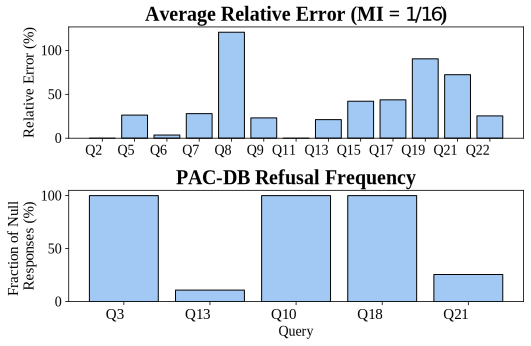

In [243]:
# Create the bar plot for unnoised times
import matplotlib as mpl
import matplotlib_inline.backend_inline

mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 5))

error_keys = avg_errors_128.keys()
error_vals = avg_errors_128.values()
ax1.bar(error_keys, error_vals, color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax1.set_xticks(x, error_keys, ha='right', fontsize=14)
# ax1.set_xlabel('Query', fontsize=16)
ax1.set_ylabel('Relative Error (%)', fontsize=15)
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax1.set_title("Average Relative Error (MI = $1/16$)", fontsize=20)


error_keys = null_pct_128.keys()
error_vals = null_pct_128.values()
ax2.bar(error_keys, error_vals,color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax2.set_xticks(x, error_keys, ha='right', fontsize=15)
ax2.set_xlabel('Query', fontsize=14)
ax2.set_ylabel('Fraction of Null \nResponses (%)', fontsize=15)
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax2.set_title("PAC-DB Refusal Frequency", fontsize=20)

plt.subplots_adjust(hspace=0.5)  # Add padding between plots
plt.tight_layout()
plt.savefig('../figs/overall_utility.png')